initializing ocelot...


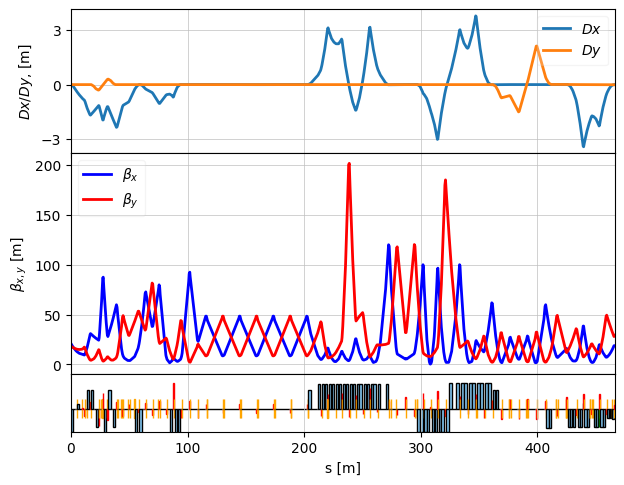

In [1]:
from ocelot import *
from ocelot.cpbd.elements import *
from ocelot.gui.accelerator import *
from ocelot.cpbd.track import track_debug
import matplotlib.pyplot as plt
import time
import numpy as np
import logging
from ocelot.cpbd.physics_proc import PhysProc
from bte import *



lat = MagneticLattice(lattice_list) 


energy = 7 # GeV

AX =1.0242202865219756 
BX =20.979549730244024   
AY =.38370813629496037
BY =18.178852478973923  
EMITX =1.2023504614117648e-06 
EMITY =1.2023504614117648e-06 


tw0 = Twiss()

tw0.alpha_x = AX
tw0.beta_x = BX

tw0.alpha_y = AY
tw0.beta_y = BY

tw0.E = energy

tw0.emit_xn = EMITX
tw0.emit_yn = EMITY
tw0.emit_x = EMITX / energy * 0.511e-3
tw0.emit_y = EMITY / energy * 0.511e-3

tws = twiss(lat,tw0)

plot_opt_func(lat, tws, top_plot = ["Dx","Dy"], legend=False, font_size=10)

################################################################################################################################################################################################

In [2]:
# import pickle

# with open("p_array_t_prueba.pkl", "rb") as f:
#     p_array = pickle.load(f)

# #  confirm:
# print("Number of particles loaded:", p_array.n)
# print("Beam energy [GeV]:", p_array.E)


In [3]:
import numpy as np
from ocelot.cpbd.beam import ParticleArray

data = np.loadtxt("particle_1_PBTE_s=0_EkMeV=6999.dat", skiprows=2)

# Optional: keep only valid particles (flag == 1)
if data.shape[1] > 6:
    data = data[data[:, 6] == 1]

# Take only the first six columns: x, xp, y, yp, z, dpp
coords = data[:, :6].T  # shape (6, N)

# --- Create ParticleArray ---
p_array = ParticleArray(n=coords.shape[1])
p_array.rparticles = coords
p_array.E = 6.999  # GeV

# --- Confirm ---
print("Number of particles loaded:", p_array.n)
print("Beam energy [GeV]:", p_array.E)
print(p_array)

Number of particles loaded: 39999
Beam energy [GeV]: 6.999
ParticleArray: 
Ref. energy : 6.999 GeV 
Ave. energy : 7.0111 GeV 
std(x)      : 0.241 mm
std(px)     : 0.017 mrad
std(y)      : 0.226 mm
std(py)     : 0.013 mrad
std(p)      : 0.0018
std(tau)    : 0.937 mm
Charge      : 0.0 nC 
s pos       : 0.0 m 
n particles : 39999



/var/folders/cc/xx3kks7j3gv2p0cdz0mm_m5h0000gn/T/ipykernel_8557/3583371127.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


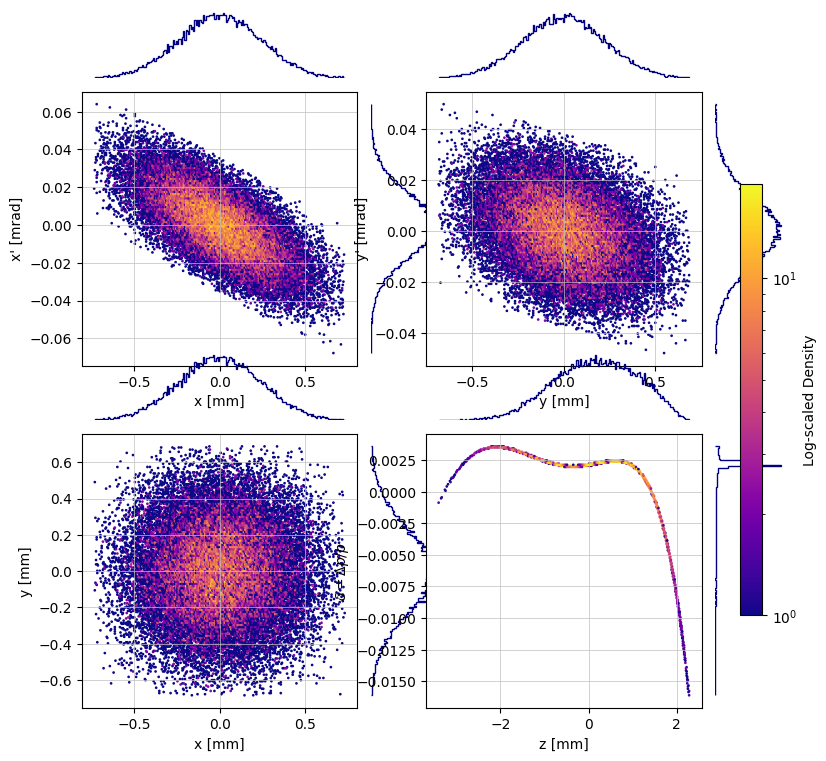

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec, colors

# --- Units conversion ---
x = p_array.rparticles[0] * 1e3
xp = p_array.rparticles[1] * 1e3
y = p_array.rparticles[2] * 1e3
yp = p_array.rparticles[3] * 1e3
z = p_array.rparticles[4] * 1e3
dp = p_array.rparticles[5]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.25)

def plot_hex(ax, x, y, xlabel, ylabel):
    # Automatic normalization
    hb = ax.hexbin(
        x, y, gridsize=200, cmap='plasma',
        bins='log',  # <-- use logarithmic color scale
        mincnt=1
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Add marginal histograms
    ax_top = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
    ax_right = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    ax_top.hist(x, bins=200, density=True, histtype='step', color='navy')
    ax_right.hist(y, bins=200, density=True, histtype='step',
                  orientation='horizontal', color='navy')
    ax_top.axis('off')
    ax_right.axis('off')
    return hb

# ---- 1. x - x' ----
hb1 = plot_hex(fig.add_subplot(gs[0, 0]), x, xp, "x [mm]", "x' [mrad]")

# ---- 2. y - y' ----
hb2 = plot_hex(fig.add_subplot(gs[0, 1]), y, yp, "y [mm]", "y' [mrad]")

# ---- 3. x - y ----
hb3 = plot_hex(fig.add_subplot(gs[1, 0]), x, y, "x [mm]", "y [mm]")

# ---- 4. z - δ ----
hb4 = plot_hex(fig.add_subplot(gs[1, 1]), z, dp, "z [mm]", r"$\delta = \Delta p/p$")

# Add a single colorbar (shared)
cbar = fig.colorbar(hb1, ax=fig.axes, label='Log-scaled Density', shrink=0.7)
plt.tight_layout()
plt.show()

In [5]:
# --- No ISR ---
navi_noISR = Navigator(lat, unit_step=1)

p_array_noISR = deepcopy(p_array)
tws_track_noISR, p_array_noISR = track(lat, p_array_noISR, navi_noISR)



z = 466.60429345389946 / 466.60429345389946. Applied: 

In [ ]:
# import random

# k1 = 1.0 + random.uniform(-0.1, 0.1)   # arc 1 (BH1E)
# k2 = k1                                  # arc 2 uses same type
# k3 = 1.0 + random.uniform(-0.1, 0.1)   # arc 3 (BH3E)


import random

# ----------------- DIPDIPOLE STRENGTH ERRORS -----------------

k1 = 1.0 + random.uniform(-0.01, 0.01)   # BH1E (arc 1)
k2 = k1                                # BH2E (arc 2 uses same magnet type)
k3 = 1.0 + random.uniform(-0.01, 0.01)   # BH3E (arc 3)

# # ----------------- MULTIPOLE ERRORS (realistic orders) -----------------
b2_err = random.uniform(-5e-3, 5e-3)    # sextupole term
# b3_err = random.uniform(-5e-4, 5e-4)    # octupole term


# ---------------- APPLY TO ARC 1 & ARC 2 (BH1E and BH2E) -----------------
for elem in lat.sequence:            
    if elem.id.startswith("BH1E") or elem.id.startswith("BH2E"):
        
        # Scale bending angle
        elem.angle *= k1
        elem.e1 = elem.angle / 2.0
        elem.e2 = elem.angle / 2.0
        
        # # Add multipole field errors
        elem.poly_b2 = b2_err
        # elem.poly_b3 = b3_err


# ---------------- APPLY TO ARC 3 (BH3E) -----------------
for elem in lat.sequence:
    if elem.id.startswith("BH3E"):
        
        elem.angle *= k3
        elem.e1 = elem.angle / 2.0
        elem.e2 = elem.angle / 2.0

        elem.poly_b2 = b2_err
        # elem.poly_b3 = b3_err




In [8]:
# --- No ISR ---
navi_t = Navigator(lat, unit_step=1)

p_array_t = deepcopy(p_array)
tws_track_t, p_array_t = track(lat, p_array_t, navi_t)

z = 466.60429345389946 / 466.60429345389946. Applied: 

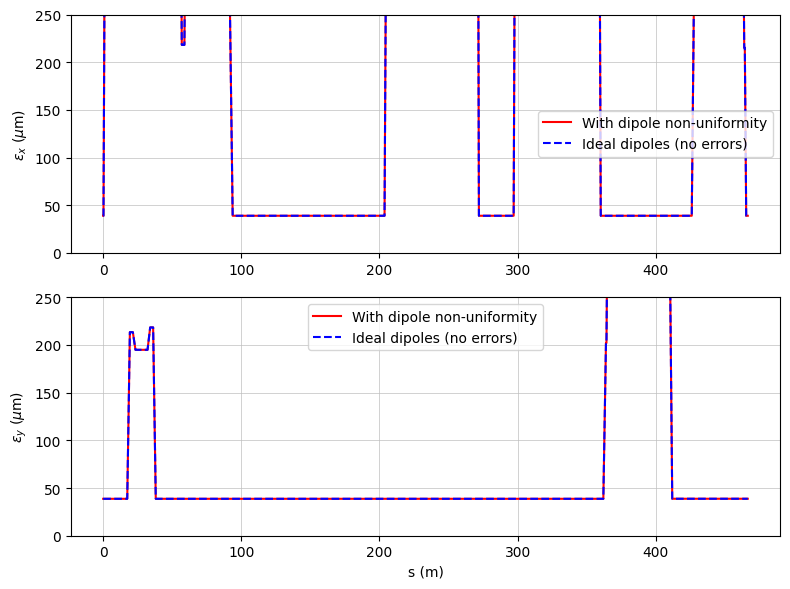

In [9]:
import numpy as np
import matplotlib.pyplot as plt

m_e_GeV = 0.000511

# --- with non-uniform SBENDs ---
s_t = [t.s for t in tws_track_t]
eps_xn_t = [t.emit_x * (t.E/m_e_GeV) * np.sqrt(1 - (m_e_GeV/t.E)**2) for t in tws_track_t]
eps_yn_t = [t.emit_y * (t.E/m_e_GeV) * np.sqrt(1 - (m_e_GeV/t.E)**2) for t in tws_track_t]

# --- with ideal SBENDs (no ISR, no errors) ---
s_noisr = [t.s for t in tws_track_noISR]
eps_xn_noisr = [t.emit_x * (t.E/m_e_GeV) * np.sqrt(1 - (m_e_GeV/t.E)**2) for t in tws_track_noISR]
eps_yn_noisr = [t.emit_y * (t.E/m_e_GeV) * np.sqrt(1 - (m_e_GeV/t.E)**2) for t in tws_track_noISR]

plt.figure(figsize=(8,6))

# ---------------------- Horizontal normalized emittance ----------------------
plt.subplot(2,1,1)
plt.plot(s_t,     np.array(eps_xn_t)*1e6,      'r-', label="With dipole non-uniformity")
plt.plot(s_noisr, np.array(eps_xn_noisr)*1e6,  'b--', label="Ideal dipoles (no errors)")

plt.ylabel(r"$\varepsilon_x$ ($\mu$m)")
plt.legend()
plt.ylim(0, 250)
plt.grid(True)

# ---------------------- Vertical normalized emittance ------------------------
plt.subplot(2,1,2)
plt.plot(s_t,     np.array(eps_yn_t)*1e6,      'r-', label="With dipole non-uniformity")
plt.plot(s_noisr, np.array(eps_yn_noisr)*1e6,  'b--', label="Ideal dipoles (no errors)")

plt.xlabel("s (m)")
plt.ylabel(r"$\varepsilon_y$ ($\mu$m)")
plt.legend()
plt.ylim(0, 250)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
for elem in lat.sequence:
    if isinstance(elem, SBend) and abs(elem.angle) > 0:
        rho = elem.l / abs(elem.angle)
        print(f"{elem.id}: L={elem.l:.3f} m, angle={elem.angle:.4f} rad, rho={rho:.3f} m")


BC1P: L=1.536 m, angle=-0.0939 rad, rho=16.361 m
BHD0: L=1.812 m, angle=0.0193 rad, rho=94.057 m
B0E: L=1.549 m, angle=0.0746 rad, rho=20.761 m
BV1UE: L=1.906 m, angle=0.0740 rad, rho=25.747 m
BV1DE: L=1.906 m, angle=-0.0740 rad, rho=25.747 m
B1E: L=2.034 m, angle=-0.1018 rad, rho=19.982 m
BV1UE: L=1.906 m, angle=0.0740 rad, rho=25.747 m
BV1DE: L=1.906 m, angle=-0.0740 rad, rho=25.747 m
B1E: L=2.034 m, angle=-0.1018 rad, rho=19.982 m
B1E: L=2.034 m, angle=-0.1018 rad, rho=19.982 m
B1E: L=2.034 m, angle=-0.1018 rad, rho=19.982 m
B1E: L=2.034 m, angle=-0.1018 rad, rho=19.982 m
B1E: L=2.034 m, angle=-0.1018 rad, rho=19.982 m
BH1AE: L=2.086 m, angle=0.0720 rad, rho=28.973 m
BH1E: L=2.079 m, angle=0.0943 rad, rho=22.050 m
BH1E: L=2.079 m, angle=0.0943 rad, rho=22.050 m
BH1E: L=2.079 m, angle=0.0943 rad, rho=22.050 m
BH1E: L=2.079 m, angle=0.0943 rad, rho=22.050 m
BH1E: L=2.079 m, angle=0.0943 rad, rho=22.050 m
BH1E: L=2.079 m, angle=0.0943 rad, rho=22.050 m
BH1E: L=2.079 m, angle=0.0943 rad